<h3>1. Global average av alla paragrafer från Sentence Transformer.</h3>

<p>Detta är den enklaste lösningen och innebär att alla paragrafer i ett uttalande skickas genom sentence transformer, varpå ett genomsnitt av dess embeddings går genom ett fully connected layer (fc) för att ge prediktioner.</p>

In [1]:
from sentence_transformers import SentenceTransformer, models
import os
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import torch
import torch.nn as nn
import re
from torch.utils.data import Dataset, DataLoader
from IPython.display import clear_output

In [127]:
from torch.masked import masked_tensor, as_masked_tensor

<p>Data över uttalanden:</p>

In [2]:
# The directory where data is located
data_dirs = ["test_data/22_23/","test_data/21_22/","test_data/20_21/"]
data = []
for data_dir in data_dirs:
    for file in os.listdir(data_dir):
        if file.endswith(".txt"):
            with open(data_dir+file,"r") as f:
                data.append([])
                for line in f.readlines():
                    data[-1].append(line)

data = np.array(data)

# Print first and last data points
#print(data[0])
#print(data[-1])

# Get only speeches
speeches = data[:,1]

<p>För varje uttalande vill vi extrahera alla paragrafer och associera dem till rätt parti.</p>

In [3]:
possible_parties = ["S","SD","M","V","C","MP","KD","L"]
regex_string = "\(("+str.join("|",possible_parties)+")\)"
print(regex_string)

parties = []
paragraphs = []
speech_index = 0
speech_indices = []

no_match = 0
for i in range(data.shape[0]):
    line = data[i,0]
    party = "None"
    match = re.search(regex_string,line)
    if match:
        party = match.group()[1:-1]
        speech = data[i,1]
        soup = BeautifulSoup(speech, 'html.parser')
        ps = soup.find_all("p")
        non_empty = 0
        for p in ps:
            text = p.get_text()
            if text != "":
                paragraphs.append(text)
                parties.append(party)
                non_empty += 1
        speech_indices.append(speech_index)
        speech_index += non_empty
    else:
        no_match += 1
    

parties = np.array(parties)
paragraphs = np.array(paragraphs)

\((S|SD|M|V|C|MP|KD|L)\)


<p>Skapa embedding-modellen.</p>

In [65]:
model_name = "paraphrase-multilingual-mpnet-base-v2"
embedding_model = SentenceTransformer(model_name)

<p>Gör embeddings av paragraferna.</p>

In [66]:
paragraph_embeddings = embedding_model.encode(paragraphs,show_progress_bar=True) #Kanske ändra maxlängd?
#torch.save(paragraph_embeddings, f="multilingual_22-23_ca50k_new.pt")

Batches:   0%|          | 0/8001 [00:00<?, ?it/s]

In [68]:
torch.save(paragraph_embeddings,f="multilingual_20-23_ca250k.pt")

In [4]:
paragraph_embeddings = torch.load("multilingual_22-23_ca50k_new.pt")

<p>Gör om partier till heltal.</p>

In [5]:
def parties_to_numbers(parties):
    return np.array([possible_parties.index(p) if p in possible_parties else 8 for p in parties])

parties = parties_to_numbers(parties)

unique, counts = np.unique(parties, return_counts=True)
dict(zip(unique, counts))

{0: 71445,
 1: 32134,
 2: 47414,
 3: 23394,
 4: 20154,
 5: 23063,
 6: 21747,
 7: 16674}

<p>Skapa datasetklassen</p>

In [6]:
class SpeechesDataset(Dataset):
    def __init__(self,paragraphs,parties,index_list,length):
        self.paragraphs = torch.Tensor(paragraphs).float()
        self.parties = torch.Tensor(parties).long()
        self.index_list = index_list
        self.length = length

    def __len__(self):
        assert self.paragraphs.shape[0] == self.parties.shape[0]
        return self.length
    
    # Get speech at a certain index
    def __getitem__(self, index):
        # The index list decides which paragraphs to use
        start, stop = self.index_list[index], self.index_list[index+1]
        paragraphs = self.paragraphs[start:stop]
        parties = self.parties[start]
        return paragraphs, parties

In [7]:
def collate_fn(data):
    input = torch.nn.utils.rnn.pad_sequence([d[0] for d in data], batch_first=True)
    lengths = torch.tensor([len(d[0]) for d in data])
    output = torch.tensor([d[1] for d in data])
    return (input, lengths), output

<p>Skapa klassificeringsmodellen:</p>

In [8]:
class SpeechClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super(SpeechClassifier, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x, lengths):
        # Input is a batch of paragraph embeddings.
        # They have different lengths and therefore the average needs to be taken over different amounts of sentences for different examples.
        avg_vector = torch.zeros((x.shape[0],x.shape[2]))
        for i in range(x.shape[0]):
            avg_vector[i,:] = torch.mean(x[i,:lengths[i],:], dim=0)
        #print("The average is "+str(avg_vector[0,:10]))
        output = self.fc(avg_vector)
        return output


<p>Choose a certain amount of speeches for training</p>

In [15]:
train_size = 5000
val_size = 1000
test_size = 1000

In [16]:

train_stop = speech_indices[train_size]
val_stop = speech_indices[train_size+val_size]
test_stop = speech_indices[train_size+val_size+test_size]

X_train = paragraph_embeddings[:train_stop]
y_train = parties[:train_stop]

X_val = paragraph_embeddings[train_stop:val_stop]
y_val = parties[train_stop:val_stop]

X_test = paragraph_embeddings[val_stop:test_stop]
y_test = parties[val_stop:test_stop]

train_indices = speech_indices[:train_size+1]
val_indices = speech_indices[train_size:train_size+val_size+1]
#Important! Make sure first index is 0
val_indices = [i-val_indices[0] for i in val_indices]
test_indices = speech_indices[train_size+val_size:train_size+val_size+test_size+1]
test_indices = [i-test_indices[0] for i in test_indices]

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

(31944, 768) (31944,) (6515, 768) (6515,) (6426, 768) (6426,)


In [17]:
train_set = SpeechesDataset(X_train, y_train, train_indices, train_size)
val_set = SpeechesDataset(X_val, y_val, val_indices, val_size)
test_set = SpeechesDataset(X_test, y_test, test_indices, test_size)

In [24]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=1000, collate_fn=collate_fn)

In [45]:
speech_classifier = SpeechClassifier(768, 8)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(speech_classifier.parameters(),lr=0.004)

In [172]:
# Construct really simple example
t = torch.rand((8,4))
lengths = torch.tensor([1,1,2,1,1,3,4,1])
avg = torch.tensor([torch.mean(t[i,:lengths[i]]) for i in range(t.shape[0])])

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
# We want avg to be 8, 1
avg = torch.zeros((8,1))

<p>Now train the classifier:</p>

In [46]:
from tqdm import tqdm

speech_classifier.train()

train_losses = []
val_losses = []
train_losses = torch.load("train_losses_model_1.pt")
val_losses = torch.load("val_losses_model_1.pt")

#batch_size = 32
epochs = 1000

for epoch in tqdm(range(epochs)):
    speech_classifier.train()
    for i, ((X_train, X_lengths), y_train) in enumerate(train_loader):
        y_pred = speech_classifier(X_train,X_lengths)
        loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Evaluate
    speech_classifier.eval()
    for i, ((X_val, X_lengths), y_val) in enumerate(val_loader):
        y_pred = speech_classifier(X_val,X_lengths)
        loss = loss_fn(y_pred, y_val)
        loss.backward()
        val_losses.append(loss.item())
    clear_output()
    print("Train loss: "+str(train_losses[-1]))
    print("Validation loss: "+str(val_losses[-1]))

100%|██████████| 1000/1000 [06:47<00:00,  2.45it/s]

Train loss: 1.355547308921814
Validation loss: 2.004695177078247


<p>Plot the losses:</p>

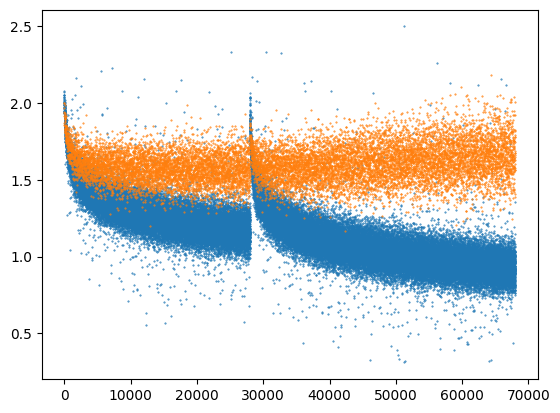

In [47]:
import matplotlib.pyplot as plt

# Save and plot losses
torch.save(train_losses,f="train_losses_model_1.pt")
torch.save(val_losses,f="val_losses_model_1.pt")

t1 = np.arange(len(train_losses))
t2 = train_size/val_size*np.arange(len(val_losses))
plt.scatter(t1,train_losses,s=0.2)
plt.scatter(t2,val_losses,s=0.2)
plt.show()

<p>Evaluate.</p>

In [48]:
y_tests = np.array([])
y_preds = np.array([])
for i, ((X_test, X_lengths), y_test) in enumerate(test_loader):
    y_pred = speech_classifier(X_test, X_lengths).softmax(dim=1).argmax(dim=1)
    y_tests = np.concatenate((y_tests,y_test))
    y_preds = np.concatenate((y_preds,y_pred))
print(i)

0


In [49]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_tests,y_preds,target_names=possible_parties))

              precision    recall  f1-score   support

           S       0.57      0.66      0.61       226
          SD       0.42      0.37      0.39       120
           M       0.55      0.51      0.53       221
           V       0.44      0.58      0.50        73
           C       0.35      0.35      0.35        81
          MP       0.33      0.33      0.33        67
          KD       0.54      0.41      0.47       119
           L       0.45      0.47      0.46        93

    accuracy                           0.49      1000
   macro avg       0.46      0.46      0.46      1000
weighted avg       0.49      0.49      0.49      1000



In [218]:
# Confusion matrix
cm = confusion_matrix(y_tests,y_preds)
print(possible_parties)
for i, r in enumerate(cm):
    print(possible_parties[i],cm[i,:])

['S', 'SD', 'M', 'V', 'C', 'MP', 'KD', 'L']
S [389  19  62  21  15  20  25  13]
SD [ 29 124  50   8   3   6  14  10]
M [ 62  32 377  11   9  16  29  25]
V [ 32  13  23 138   5  15   3   3]
C [34 11 41 11 75 12 13  2]
MP [ 24  12  15   7   5 107   8   4]
KD [ 24  13  44   7  11  13 152  10]
L [ 22   7  49  12   4  11  16 123]


In [225]:


for i, ((X_test, X_lengths), y_test) in enumerate(test_loader):
    y_pred = speech_classifier(X_test, X_lengths).softmax(dim=1).argmax(dim=1)
    print("Speech: ")
    print(speeches[i+train_size])
    print("Prediction: "+possible_parties[y_pred])
    print("True: "+possible_parties[y_test])
    if i == 10:
        break

Speech: 
<p>Herr talman! Enligt Wikipedia är cirkulär ekonomi "ett uttryck för ekonomiska modeller för affärsmöjligheter där cirkulära kretslopp i ett företag, samhälle eller en organisation används snarare än linjära processer som hittills har varit dominerande".</p><p>Jag är inte helt enig med den definitionen, herr talman. I många delar vill jag absolut hävda att cirkulär ekonomi snarare har varit det dominerande fram till relativt nyligen, detta inte i första hand av hänsyn till miljö och klimat utan snarare av hänsyn till ekonomin eftersom den inte tillät annat. Då visste man inte heller att det hette "cirkulär ekonomi".</p><p>Kläder är väl ett av de tydligaste exemplen, och jag räknar med att det är flera här i kammaren som känner igen sig. I alla fall under min uppväxt var ärvda kläder det mest självklara i världen. Med största sannolikhet var man inte heller den första i kedjan att ärva kläderna, utan det var någon annan som hade haft kläderna tidigare. Var det någon av de stor

In [44]:
#Save the model
torch.save(speech_classifier.state_dict(),"baseline.pth")

In [252]:
test_speech = np.array(["Jämlikhet!", "Höj skatterna tycker vi i vänsterpartiet!"])
emb = torch.tensor([[embedding_model.encode(s) for s in test_speech]])
print(possible_parties[speech_classifier(emb, torch.tensor([2])).softmax(dim=1).argmax(dim=1)])

L
